<a href="https://colab.research.google.com/github/davanstrien/introduction-to-computer-vision-workshop/blob/main/cv-deep-learning-pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission

In [ ]:
!mv /content/Programming-Historian-Computer-Vision-Lessons-submission/deep-learning/ads_data .

In [ ]:
!pip install fastai --upgrade

# Computer Vision for the Humanities: an introduction to deep learning for image classification, part 2

## authors:
- Daniel van Strien 
- Kaspar Beelen
- Melvin Wevers
- Thomas Smits
- Katherine McDonough

# A Full Deep Learning Pipeline

This is the second part of a series of lessons. We assume you have already done part one of the lesson which also includes setup instructions. 

In the previous lesson, we introduced the process of creating an image classifier model and looked at some of the key steps in a deep learning pipeline. 

In this lesson, we will move in more detail through the steps involved in creating a deep learning model, from exploring the data, to training the model. This will reinforce some of the concepts that were discussed in the previous lesson. 

As a reminder, we can think of the process of creating a deep learning model as a pipeline of related steps. In this lesson we will move through this pipeline step by step:

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/deep-learning-pipeline-simple.png)

## The Data

We will again work with the ['newspaper navigator'](news-navigator.labs.loc.gov/) dataset. However, this time the images will be those predicted as being photos. These photos are sampled from 1895 to 1920. Benjamin Lee, one of the creators of the dataset, offers a fuller discussion of the 'archeology' of this dataset.'[^lee]

#### Working with Errors

It is important to understand the data you are working with both as a historian and when applying deep learning. Since the data from Newspaper Navigator is predicted by a machine learning model it will contain errors. The project page for Newspaper Navigator prominently shares an "Average Precision" metric for each category:

| Category | Average Precision | # in Validation Set |
| ----- | ----------------- | ----------------- |
| Photograph | 61.6% | 879 |
| Illustration | 30.9% | 206 |
| Map | 69.5% | 34 |
| Comic/Cartoon | 65.6% | 211 |
| Editorial Cartoon | 63.0% | 54 |
| Headline | 74.3% | 5,689 |
| Advertisement | 78.7% | 2,858 |
| Combined | 63.4% | 9,931 |

[Reference](https://github.com/LibraryOfCongress/newspaper-navigator/blob/master/README.md)

We'll look more closely at metrics later in this lesson, but for now, we can note that errors will include visual material which has been missed by the model, as well as images which have been given an incorrect category i.e. a photograph classified as an illustration. For average precision, a higher number is a better score. The average precision score varies across image type with some classes of image performing better than others. The question of how good is 'good enough' will depend on the intended use of these models. Working with some errors is usually a requirement of working with machine learning, since most models will produce some errors. It is helpful that the performance of the model is shared in the [GitHub repository](https://github.com/LibraryOfCongress/newspaper-navigator) for this work. This is something we will also want to do when we share data or research findings generated via machine learning methods. 

### Using a Model to Assign Labels

So far, we looked at using computer vision to create a model which classified images into one of two categories ('illustrated' or 'text only'). Whilst we can create a model which classifies images into one of a larger number of categories, an alternative approach is to use a model which assign labels to the images. Using this approach, an image can be associated with a single label, multiple labels, or no labels. For the dataset we are now working with (images from 'newspaper navigator' which were predicted as being photos), images have had labels applied rather than being classified.

Depending on how you want to apply computer vision, a model which does classification or assigns labels might be more suitable. The data you are working with will also partially determine whether it is possible to assign images to a single category or not. Classifying adverts into two categories of 'illustrated' or 'not illustrated' was relatively easy. There were some 'edge cases', for example, adverts which contained [manicules](https://en.wikipedia.org/wiki/Index_%28typography%29), which could be considered as a form of typography and therefore not an illustration. However, it would also not be unreasonable to argue that the manicules play a different intended -  or actual - role in communicating information compared to other typography, and therefore should be classed as an illustration. Even in this relatively simple classification example, we are beginning to see the potential limitations of classifying images.

Models that assign labels instead of performing classifications offer some advantages in this regard since these labels can operate independently of each other. When using a classification model, an image will always be 'pushed' into one (and only one) of the possible categories (for example an advert with an illustration or without).  In contrast, a model which applies labels can assign label $a$ without precluding the option of also assigning label $b$. A model which assigns labels may also choose 'I don't know' or 'none of the above', by not assigning any labels. 

We can use an analogy to illustrate the difference between these two approaches. Let's say you were sorting through some old family photographs. You might "classify" the photos into one (and only one) of two photo albums, depending on whether they are black-and-white or colour.  This would be comparable to using a classification model since each photo will go into exactly one of these two albums - a photo cannot be both simultaneously colour *and* black-and-white, and it cannot be neither colour *nor* black-and-white.

You may at the same time also want to make it easier to find photos of particular people in your family. You could do this by assigning labels to each photo, indicating or "tagging" the family members who appear in the photo. In this case, a photo may have one label (a photo of your sister), more than one label (a photo of your sister *and* aunt), or it may have no labels (a photograph of a landscape taken on a holiday). This would be analogous to our multi-label classification model. 

The choice between using a model which performs classification or a model which assigns labels should be considered in relation to the role your model has. You can find a more detailed discussion of the differences in these approaches in this [blog post](https://danielvanstrien.xyz/models/labels/loss%20functions/2020/10/12/labelling_vs_classification_models.html). It is important to remember that a model makes predictions - there is then a second step of deciding what action (if any) to make based on those predictions. 

## Looking at the Data

It is important to understand our data before trying to use it for deep learning, so we'll start by loading the data into a pandas `DataFrame`. [pandas](https://pandas.pydata.org/) is a Python library which is useful for working with tabular data, such as the type of data you may work with using a [spreadsheet](https://en.wikipedia.org/wiki/Spreadsheet) software such as [Excel](https://en.wikipedia.org/wiki/Microsoft_Excel). Since this isn't a tutorial on pandas, don't worry if you don't follow all of the pandas code in the section below fully. If you do want to learn more about pandas, you might want to look at the ['Visualizing Data with Bokeh and Pandas'](https://programminghistorian.org/en/lessons/visualizing-with-bokeh) Programming Historian lesson. 

The aim here is to use pandas to take a look at some of the features of this dataset. This step of trying to understand the data you will be working before training a model is often referred to as ['exploratory data analysis'](https://en.wikipedia.org/wiki/Exploratory_data_analysis) (EDA).

<div class="alert alert-warning">
   Although it's not necessary to be familiar with pandas to follow this lesson, becoming familiar with pandas can be very useful for deep learning because it allows you to efficiently work with tabular data, which will often include training data for deep learning models. Some suggested resources are included at the end of this lesson. 
</div>

First we import the pandas library. By convention pandas is usually imported `as` pd.

In [ ]:
import pandas as pd

We will also import [Matplotlib](https://matplotlib.org/). We will tell Matplotlib to use a different [style](https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html) using the `style.use` method. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

For this dataset, our labels are stored in a csv file again. Let's load it into a `DataFrame` stored in a variable `df`. This is a standard convention used for naming pandas `DataFrames`.

In [ ]:
df = pd.read_csv('photo_data/multi_label.csv', na_filter=False)

Let's now take a look at what the dataframe looks like. Remember, when working in a Jupyter notebook, we don't need to use `print` to display variables which are on the last line of our code block. 

In [ ]:
df

,file,label
0,vi_yes_ver01_data_sn84025841_00175032307_18970...,human|landscape
1,dlc_frontier_ver01_data_sn84026749_00280764346...,human
2,wa_dogwood_ver01_data_sn88085187_00211108150_1...,human
3,hihouml_cardinal_ver01_data_sn83025121_0029455...,human
4,ct_cedar_ver01_data_sn84020358_00271744456_190...,human
...,...,...
1997,ak_jellymoss_ver01_data_sn84020657_0027952701A...,human|human-structure
1998,njr_cinnamon_ver03_data_sn85035720_00279529571...,human
1999,dlc_liberia_ver01_data_sn83030214_00175041394_...,human
2000,uuml_dantley_ver01_data_sn85058130_206534618_1...,human


By default, we'll see a sample of the `DataFrame`. We can already learn a few things about our data. Firstly, we have `2002` rows. This is the maximum size of our potential training + validation datasets. We can also see three columns, the first is a pandas [`Index`](https://pandas.pydata.org/pandas-docs/stable/reference/indexing.html), the second column is the path to the image files, the third is the labels column. 

It is useful to explore the properties of a dataset before using it to train a model. If you created the training labels for the dataset you will likely already have a sense of the structure of the data but it is still useful to empirically validate this. We can start by looking at the label values. In pandas we can do this with the ```value_counts()``` method on a Pandas Series (i.e. a column) to get the counts for each value in that column. 

In [ ]:
df['label'].value_counts()

human                                     1363
human-structure                            164
                                           117
human|human-structure                      106
human-structure|landscape                   48
landscape                                   40
human|landscape                             40
animal                                      26
human|animal|landscape                      26
human|human-structure|landscape             20
human|animal                                19
human|animal|human-structure                16
animal|human-structure                       8
animal|landscape                             4
animal|human-structure|landscape             3
human|animal|human-structure|landscape       2
Name: label, dtype: int64

This is a start, but we can see that because the labels for each image are stored in the same column with a `|` separator, we don't get the proper number of label counts. Instead, we see the combinations of labels. Human is often a single label, and human/human-structure are often together. What we really want is to see how often each *individual* label appears. 

First, lets export the label column from the Pandas `DataFrame` to a Python `list`. We can do this by indexing into the Pandas column for labels, and then using the [`to_list()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.to_list.html?highlight=to_list#pandas.Series.to_list) pandas method to convert the Pandas column to a list. 

Once we've done this, we can take a slice from this list to display a few examples. 

In [ ]:
# create a variable lables to store the list
labels = df['label'].to_list() 
# take a slice of this list to display
labels[:6] 

['human|landscape', 'human', 'human', 'human', 'human', 'human']

Now we have the labels in a list, we still have items in the list such as ```'human|animal|human-structure'``` which include multiple labels. We need to split on the `|` symbol to access each label. There are various ways of doing this. We'll tackle this using a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). If you haven't come across list comprehension before, it is similar to a `for loop`, but can be used to directly create or modify a python list. We'll create a new variable `split_labels` to store the new list.

In [ ]:
# for each label in the list split on "|"
split_labels = [label.split("|") for label in labels] 

Let's see what this looks like now by taking a slice of the list

In [ ]:
split_labels[:4]

[['human', 'landscape'], ['human'], ['human'], ['human']]

We now have all of the labels split out into individual parts. However, because the python [```split```](https://docs.python.org/3.8/library/stdtypes.html?highlight=split#str.split) method returns a list, we have a list of lists. We could tackle this in a number of ways. Below, we use another list comprehension to [flatten](https://stackoverflow.com/a/952952) the list of lists into a new list. 

In [ ]:
labels = [label for sublist in split_labels for label in sublist]
labels[:4]

['human', 'landscape', 'human', 'human']

We now have a single list of individual labels. To get the frequencies of these labels we can use the `Counter` class from the Python `Collections` module:

In [ ]:
from collections import Counter
label_freqs = Counter(labels)

`Counter` returns a Python `dictionary` with the labels as `keys` and the frequency counts as `values`. We can look at the values for each label:

In [ ]:
label_freqs

Counter({'human': 1592,
         'landscape': 183,
         'human-structure': 367,
         '': 117,
         'animal': 104})

We can also see how many total labels we have in this dataset, by accessing the `values` attribute of our dictionary, using `values()` and using `sum` to count the total: 

In [ ]:
sum(label_freqs.values())

2363

Although we have a sense of the labels already, visualizing the labels may help us understand their distribution more easily. We can quickly plot these values using the `matplotlib` python library to create a bar chart. 

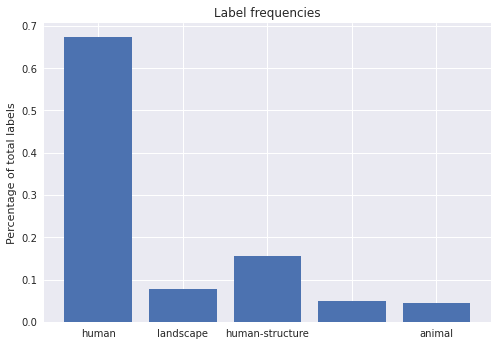

In [ ]:
import matplotlib.pyplot as plt

plt.bar(
    label_freqs.keys(),  #pass in our labels 
    list(map(lambda x: x / sum(label_freqs.values()), label_freqs.values())),  # normalized values
)
# add a title to the plot
plt.title("Label frequencies")
# add a y axis label
plt.ylabel("Percentage of total labels")
plt.show()  # show the plot

<div class="alert alert-warning">
   The above plot could be improved, and we would want to do this if we were intending to use it for a publication. However, it can often be useful to create basic visualizations of our data as a way of exploring the data, or debugging problems - for these purposes it doesn't usually make sense to spend too much time creating the perfect visualization. 
</div>

### Using these Labels

This plot helps show the balance between the different labels, including some photos which have no labels (the bar above with no label). This dataset poses a few new challenges for us. Firstly we might be concerned that the model will become much better at predicting humans in comparison to the other labels, since there many more examples of that for the model to learn from. Another challenge is how to evaluate the success of this model; which metric should we use?

### Choosing a Metric  

In our previous ad classification dataset `accuracy` was used as a measure. Accuracy can be shown as:

$$Accuracy = \frac{\text{Correct Predictions}}{\text{Total Predictions}}$$

Accuracy is an intuitive metric, since it shows the proportion of correct predictions compared to the total number of predictions. For this reason it often a useful first metric to consider. However, there are limitations to using accuracy. In our previous dataset we had just two classes, with a balance between labels[^balance], as there were the same number of examples for each label: 50% ads with images and 50% ads with no image. In this example, we could reasonably say then that if you predicted randomly, you would have an accuracy of around 50%. However. if the dataset is not evenly balanced between labels, this is no longer true. 

As an extreme example, take a hypothetical dataset with a 100 data points, with label $A$ for 99 and label $B$ for 1. For this dataset always predicting label $A$ would result in an accuracy of 99% ($99/100$). An accuracy metric in this example is not very useful since our model isn't at all good at predicting label $B$, yet we still get an accuracy of 99%, which sounds very good. Depending on the labels you are interested in, it is possible that they will be relatively 'rare' in your dataset, in which case accuracy may not be a helpful metric. Fortunately, there are other metrics which can help overcome this potential limitation.

### F-Beta 

The key issue we identified with accuracy as a metric was that it could hide how well a model is performing for imbalanced datasets. In particular, it doesn't provide information on two particular things we might care about: precision and recall. 

Precision is the ratio of correct positive predictions to the total number of positive predictions, which can be shown as:

$$Precision = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

Recall is the ratio of correct positive predictions to the total number of positive examples in the dataset, which can be shown as:

$$recall = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$

As you may have noticed, the precision metric is a measure of how precise a model is in identifying labels i.e. this metric 'penalizes' making extra wrong guesses (false positives). On the other hand, the recall metric measures how much a model misses i.e. it 'penalizes' missing labels (false negatives). 

How much we care about each of these depends on our data and how we want to use the model. We can see how in some settings we may care more about recall than precision, and having these two measures available allows us to favor one or the other. 

If we care about some compromise between the two, we could use F-Beta measure (sometimes shown as $F\beta$). The F-Beta score is the weighted [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of precision and recall. The best possible F-beta score is 1, the worst 0. The Beta part of F-Beta is a weighting which can be used to give more weight to precision or recall. A Beta value <1 will give more weight to precision, whilst a weighting > 1 will give more weight to recall. An even weighting of these two is often used i.e. a Beta of 1. This score is often also referred to as the "F-score" or "F-measure". This is the measure we will use for our new dataset.

<div class="alert alert-warning">
Remember, metrics don't directly impact the training process. The metric gives the human training the model feedback on how well it is doing, but isn't used by the model to update the model weights. 
</div>

## Loading Data

Now that we have a better understanding of the data, we'll move to the next step in our pipeline. In particular, we'll look at how we can prepare data in a form that a deep learning model (in this case a computer vision model) can understand. We want to prepare data in such a way that images and labels are put into batches which can be passed to our model. 

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/training-loop.jpg)

fastai provides a number of useful APIs for loading data. These APIs move from a 'high level' API which provides useful 'factory methods', to 'mid-level' and 'low-level' APIs which offer more flexibility in how data is loaded. We'll use the 'high level' API for now to keep things straightforward.

First we should load in the fastai vision modules. 

In [ ]:
from fastai.vision.all import *

 For our last dataset we loaded our data from a `csv` file using the `.from_csv()` method. Since we now have our data loaded into a pandas `DataFrame` we'll instead use this `DataFrame` to load our data. We can remind ourselves of the column names by accessing the `columns` attribute of a DataFrame:

In [ ]:
df.columns

Index(['file', 'label'], dtype='object')

The code for loading from a `DataFrame` is fairly similar to the method we used before. There are a few additional things we need to specify to load this data. The code is commented to show what each line does but some key things to point out are: 

- `bs` (batch size). As we saw earlier, most deep learning models take data one batch at a time. `bs` is used to define how many data points (in our case images) should go into a batch. Often [32 is a good starting point](https://arxiv.org/abs/1804.07612), but if you are using large images, or have a GPU with less memory you may need to reduce the number to 16 or 8. If you have a GPU with a lot of memory you may be able to increase `bs` to a higher number. 
- `label_delim` (label delimiter). Since we have multiple labels in the label column, we need to tell fastai how to split those labels, in this case on the `|` symbol. 
- `valid_pct` (validation percentage). This is the amount (as a percentage of the total data) that we want to use as validation data. In this case we use 30%, but the amount of data you hold out as validation data will depend on the size of your data, the distribution of your labels and other considerations. An amount between 20-30% is often used. You can find a more extensive discussion from fastai on [how (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/).

In [ ]:
photo_data = ImageDataLoaders.from_df(
    df,  # the dataframe where our labels and image file paths are stored
    folder="photo_data/images",  # the path to the directory holding the images
    bs=32,  # the batch size (number of images + labels)
    label_delim="|",  # the deliminator between each label in our label column
    item_tfms=Resize(224),  # resize each image to 224x224
    valid_pct=0.3,  # use 30% of the data as validation data
    seed=42  # set a seed to make results more reproducible
)

### fastai DataLoaders

We have created a new variable using a method from `ImageDataLoaders` - lets see what this is. 

In [ ]:
photo_data

The `ImageDataLoaders.from_df` method produces something called `DataLoaders`. `DataLoaders` are the way in which fastai prepares our input data and labels to a form that can be used as input for a computer vision model. It's beyond the scope of this lesson to fully explore everything this method does 'under the hood', but we will have a look at a few of the most important things it does in this section. 

#### Viewing our Data
We have already seen an example of `show_batch`, this method will allow you to preview some of your data and labels. We can pass a `figsize` to control how large our displayed images are. 

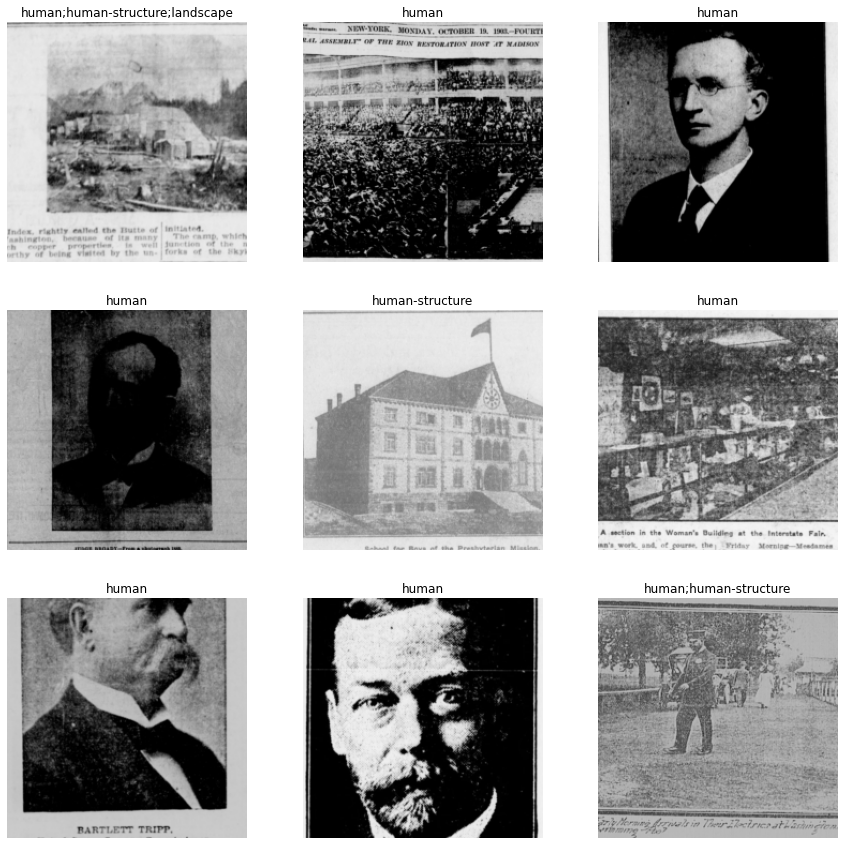

In [ ]:
photo_data.show_batch(figsize=(15,15))

### Inspecting Model Inputs

Our model takes labels and data as inputs. To help us understand some more of the details of the deep learning pipeline we can inspect these both in more detail. We can access the `vocab` attribute of our data to see which labels our data contains. 

In [ ]:
photo_data.vocab

['animal', 'human', 'human-structure', 'landscape']

We can see here that we have the four labels we expect. 

As mentioned previously, deep learning models use the underlying numerical representation of images, rather than 'seeing' images in the same way as a human. We also saw in the outline of the training process that model training usually happens in `batches`. When `photo_data` was created above `bs=32` was specified. We can access a single batch in fastai using `one_batch()`. We'll use this to inspect what the model gets as input. 

Since our data is made up of two parts; the input images, and the labels, `one_batch()` will return two things. We will store these in two variables: `x` and `y`.

In [ ]:
x, y = photo_data.one_batch()

<div class="alert alert-warning">
When you learned Python, you were likely told to use meaningful variable names, yet 'x' and 'y' variable names seem to be the opposite of this. More verbose naming is usually a sensible approach, however, within particular disciplines standard conventions are adopted. In machine learning, 'x' is commonly understood as the input data and 'y' as the target labels to be predicted.
</div>

We can start by checking what 'type' `x` and `y` are. We can do this using the Python `type` function. 

In [ ]:
type(x), type(y)

(fastai.torch_core.TensorImage, fastai.torch_core.TensorMultiCategory)

These types will likely not be ones you have seen before since these are specific to `fastai`,  but we can see that `x` is a `TensorImage` and `y` is `TensorMultiCategory`. A ["Tensor"](https://pytorch.org/docs/stable/tensors.html) is a 'n-dimensional array'; in this case one for storing images, and one for storing multiple labels. We can explore these in more detail to inspect what both of these `Tensors` look like. To start, we can take a look at the length of both `x` and `y`:

In [ ]:
len(x), len(y)

(32, 32)

Remember that when we loaded our data, we defined a batch size of 32, so this length represents all of the items in one batch.  Let's take a look at a single example from that batch. We can use the standard python indexing to the access the first element of `x`

In [ ]:
x[0]

tensor([[[0.7020, 0.7412, 0.7765,  ..., 0.6706, 0.6902, 0.7137],
         [0.7333, 0.7294, 0.7451,  ..., 0.3137, 0.3255, 0.3569],
         [0.4706, 0.4000, 0.3686,  ..., 0.0902, 0.1098, 0.1137],
         ...,
         [0.0275, 0.0510, 0.0314,  ..., 0.1176, 0.1373, 0.1255],
         [0.0118, 0.0118, 0.0118,  ..., 0.5529, 0.5373, 0.4824],
         [0.2863, 0.3255, 0.3333,  ..., 0.5490, 0.4078, 0.3647]],

        [[0.7020, 0.7412, 0.7765,  ..., 0.6706, 0.6902, 0.7137],
         [0.7333, 0.7294, 0.7451,  ..., 0.3137, 0.3255, 0.3569],
         [0.4706, 0.4000, 0.3686,  ..., 0.0902, 0.1098, 0.1137],
         ...,
         [0.0275, 0.0510, 0.0314,  ..., 0.1176, 0.1373, 0.1255],
         [0.0118, 0.0118, 0.0118,  ..., 0.5529, 0.5373, 0.4824],
         [0.2863, 0.3255, 0.3333,  ..., 0.5490, 0.4078, 0.3647]],

        [[0.7020, 0.7412, 0.7765,  ..., 0.6706, 0.6902, 0.7137],
         [0.7333, 0.7294, 0.7451,  ..., 0.3137, 0.3255, 0.3569],
         [0.4706, 0.4000, 0.3686,  ..., 0.0902, 0.1098, 0.

Although it isn't super clear from looking at this output, this is the first image in our batch in the format in which it will be passed to the model. Since this output isn't very meaningful for us to interpret, let's access the `shape` attribute:

In [ ]:
x[0].shape

torch.Size([3, 224, 224])

This output is hopefully more meaningful. The first dimension `3` refers to the number of channels in our image (since the image is an [RGB](https://en.wikipedia.org/wiki/RGB_color_model) image). The other dimensions `224` are the size we specified when we loaded our data `item_tfms=Resize(224)`. 

Now we have inspected `x`, the input images, we'll take a look at the `y`, which holds the labels. Again, we can index into the first `y`:

In [ ]:
y[0]

tensor([0., 0., 0., 0.], device='cuda:0')

We can see that the first `y` is also a tensor. However, this label tensor looks different from our image example. In this case, we can easily manually count the number of elements. However, to be sure let's access the `shape` attribute:

In [ ]:
y[0].shape

torch.Size([4])

So we have four elements in our first `y`. These are 'one hot encoded' versions of our labels. ['One hot encoding'](https://en.wikipedia.org/wiki/One-hot) is a way of expressing labels where `0` is no label and `1` is a label. So in this case we have just no labels in the vocab present in the label tensor for the first image. 

Now we can finally take a look at the first batch as a whole:

In [ ]:
x.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 4]))

Again, this can be useful to verify that data looks as you would expect. It is also a useful way of 'poking' around to see how data is prepared for the model. Now we have had a look at what our data looks like, we'll examine some potential ways to maximize our fairly modest dataset. 

## Image Augmentations 


Image augmentations are a type of [Data augmentation](https://en.wikipedia.org/wiki/Data_augmentation), and represent one of the methods we can use to try to reduce the amount of training data required and help prevent overfitting our model. As a reminder, overfitting occurs when the model gets very good at predicting on the training data but doesn't generalise well to the validation data. Image augmentations are a method of artificially creating more training data. Looking at an example will help illustrate how this works.

In [ ]:
tfms = aug_transforms(do_flip=True, max_rotate=10.0, max_zoom=1.1, min_scale=0.75)

In [ ]:
photo_data = ImageDataLoaders.from_df(
    df,  # dataframe containing paths to images and labels
    folder="photo_data/images",  # folder where images are stored
    bs=32,  # batch size
    label_delim="|",  # the deliminator for multiple labels
    item_tfms=Resize(224),  # resize images to a standard size
    batch_tfms=[*tfms],  # pass in our transforms
    valid_pct=0.3,  # 30% of data used for validation
    seed=42,  # set a seed,
)

In this example, we keep everything the same as before, except we now add a function `aug_transforms` to create some image transformations. We pass this into the `batch_tfms` parameter in the `ImageDataLoader`. In the previous lesson, we saw `item_tfms` in our advert data loading example. What is the difference between these two transforms? 

`item_tfms`, as the name suggests, are applied to each item before they are assembled into a batch, whereas `batch_tfms` are instead applied to batches of images - in our case 32 images at a time. The reason we should use `batch_tfms` when possible, is that they happen on the GPU and as a result are much faster. However, if you don't have a GPU available, they will still work. 

Now we have passed some augmentations to our data, we should take a look at what the data looks like. Since we are now concerned with  the transformations in particular, it will be easier to compare if we look at the same image. We can do this by passing the `unique=True` flag to `show_batch()`

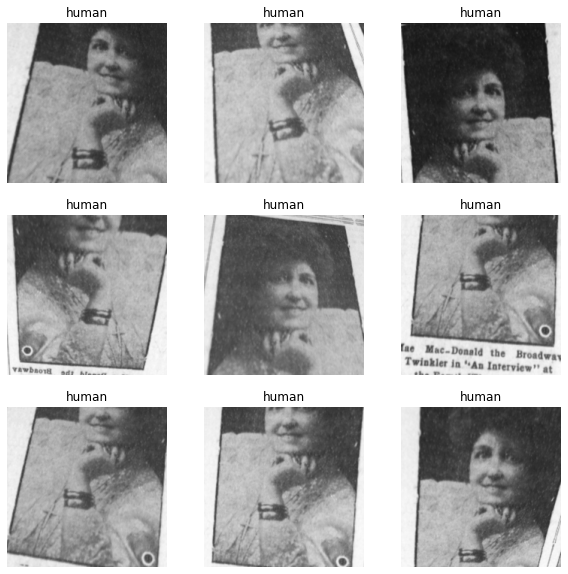

In [ ]:
photo_data.show_batch(unique=True, figsize=(10,10))

We can see that the same image has been manipulated in a variety of ways, including zooms and rotations. Why would we want to do this? 

We can see the transformed images all look a little bit different. However, we also see that they have the same label. Image transforms or `augmentations` are useful because they allow us to artificially increase the size of our training data. For the model the transformed images all represent new training examples - but we didn't have to actually label all of these different examples.

The catch is that we usually want to try and use transformations that are actually likely to represent *real* variations in the types of data our model will work with. The default transformations may not match with the actual variation seen in new data, which might harm the performance of our model. For example, a standard transform is to mimic variations in lighting in an image. This may work well where input data is photographs taken 'in the wild', but our images have largely been produced by digitising microfilm, and therefore the types of variations will be different to those seen in 'everyday photography'. We want to be aware of this, and will often want to modify or create our own transformations to match our data.

<div class="alert alert-warning">
We don't have space in this lesson to fully explore transformations. We suggest exploring different transformations <a href="https://docs.fast.ai/vision.augment#aug_transforms">  available in the fastai library</a> and thinking about which transformations would be suitable for a particular type of image data. 
</div>

## Creating a Model

Now we have loaded data, including applying some augmentations to the images, we are ready to create our model, i.e. moving to our training loop. 

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/training-loop.jpg)

Again, we have seen this at a high level before, and most things will remain the same as in our previous advert example. 

We again use `ccn_learner` to create a model. We now know that the "cnn" refers to a type of deep learning model. We again pass our data in, and an existing model architecture we want to use. 

This time we use a ["DenseNet"](https://arxiv.org/abs/1608.06993) model architecture instead of the "ResNet" model which was used in our previous example. This is done to show how we can experiment with different model architectures supported by fastai. Although "ResNets" are good starting point you should feel free to also experiment with other models. 

We again pass in some `metrics`. We use `F1ScoreMulti` since we want to use F1 as a metric on a dataset with multiple labels. We also pass in `accuracy_multi`; this is a multi-label version of accuracy. We include this to illustrate how different metrics can give very different scores for the performance of our model. 

In [ ]:
learn = cnn_learner(photo_data, densenet121, metrics=[F1ScoreMulti(), accuracy_multi])

<div class="alert alert-warning">
You may have spotted that F1ScoreMulti() has a brackets at the end. This is because this particular metric is a class that needs to be instantiated before it can be used. Some other metrics in the fastai library will need to be instantiated before they can be used. It is usually possible to spot these because they are in CamelCase as opposed to snake_case. 
</div>

Now we have created our model, and stored it in the variable `learn`, lets look at what this is. This time we'll use a nice feature of Jupyter notebooks, which allows you to easily access documentation about a library. 

In [ ]:
?learn

Signature:      learn(event_name)
Type:           Learner
String form:    <fastai.learner.Learner object at 0x7fb336eb5790>
File:           /anaconda/lib/python3.7/site-packages/fastai/learner.py
Docstring:      Group together a `model`, some `dls` and a `loss_func` to handle training
Call docstring: Call `event_name` for all `Callback`s in `self.cbs`


In a notebook, placing `?` in front of a library, method or variable will return the `Docstring`. This can be a useful way of accessing documentation. In this example, we see that a learner groups our model, our data `dls` and a "loss function". Helpfully, fastai will often infer a suitable `loss_func` based on the data it is passed. 

## Training the Model

The fastai `learner` contains some powerful functionalities to help train your model. One of these is the learning rate finder. As a reminder, a learning rate determines how aggressively we update our model after each batch. If the learning rate is too low, the model will only improve very slowly. If the learning rate is too high, the loss of the model will go up, i.e. the model will get worse rather than better. fastai includes a method `lr_find` which helps with this process. Running this method will start a progress bar before showing a plot.

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.04786301031708717)

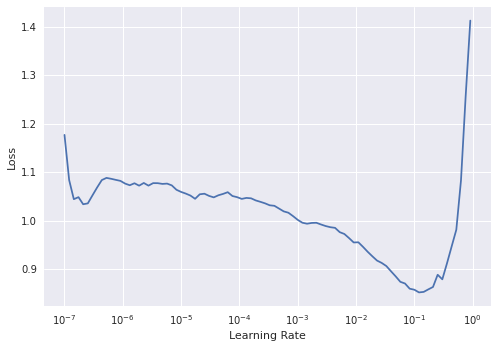

In [ ]:
learn.lr_find()

`lr_find` helps find a suitable learning rate by training on a "mini batch", and slowly increasing the learning rate until the loss starts to get much worse. We can see in this graph that on the y-axis we have the `loss` and on the x-axis `Learning Rate`. The loss moves down as the learning rate increases, up to a point, before it shoots up. 

We want to pick a point where the loss is going down steeply, since this should be a learning rate which will allow our model to update quickly whilst avoiding the point where the loss shoots up. In this case we'll pick `2e-2`. 

Picking a good learning rate is one of the important variables that you should try and control in the training pipeline. A useful exercise is to try out a range of different learning rates with the same model and data to see how it impacts the training of the model. 

### Fitting the Model 

We are ready to train our model. We previously used the `fine_tune` method, but we can also use other methods to train our model. In this example we will use a method called [`fit_one_cycle`](https://docs.fast.ai/callback.schedule#Learner.fit_one_cycle). This method implements an approach to training described in a [research paper](https://arxiv.org/pdf/1708.07120.pdf) that was found to improve how quickly a model trains. The fastai library implements many best practices in a way that makes them easy to use. For now we'll train the model for 5 epochs using a learning rate 2e-2

In [ ]:
learn.fit_one_cycle(5, lr_max=2e-2)

epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.609265,0.378603,0.435054,0.883750,00:35
1,0.451798,0.582571,0.507082,0.793333,00:31
2,0.360973,0.271914,0.447796,0.908333,00:32
3,0.298650,0.201173,0.593643,0.913750,00:31
4,0.247258,0.194849,0.628454,0.922500,00:32


Most of this output is similar to the output we got when training our previous model. One difference is that this time we only get one set of outputs, rather than the two we had in the ads example. This is because we are no longer unfreezing the model during the training step, and are only training the last layers of the model. The other layers of the model are using the weights learned from training on ImageNet, so we don't see a progress bar for training these layers.

Another difference is that now we have two different metrics; `f1_score` and `accuracy_multi`. The potential limitations of accuracy are made clearer in this example. If we took used accuracy as our measure here, we could mistakenly think our model is doing much better than is reflected by the F1-Score. 

We also get an output for `train_loss` and `valid_loss`. As we have seen, a deep learning model has some way of calculating how wrong it is, using [loss function](https://en.wikipedia.org/wiki/Loss_function). The 'train' and 'valid' refer to the loss for the training and validation data. It can be useful to see the loss for both of these to see how whether our model performs very differently on the training data in compared to the validation data. Although the loss values can be tricky to directly interpret, we can use the change of these values to see whether our model is improving (we would expect loss to go down when the model is improving). We can also access the `recorder` attribute of our `learner` to `plot_loss`; this will give us a visual sense of how the training and validation loss change as the model is trained. 

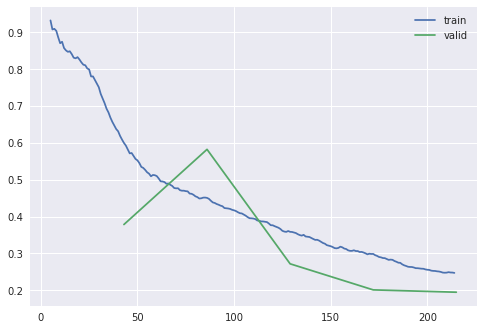

In [ ]:
learn.recorder.plot_loss()

Compared to our previous model, we are not getting a very good score. Let's see if "unfreezing" the model (updating the lower layers of the network) helps improve the performance.

#### Saving Progress

Since training a deep learning model takes time and resources, it is useful to save progress as we train our model. This is particularly useful since it is possible to overfit a model, or do something else which makes it perform more poorly than previous epochs. To save the model, we can use the `save` method and pass in a `string` value to name this save point, allowing us to return to this point if we mess something up later on. 

In [ ]:
learn.save('stage_1')

Path('models/stage_1.pth')

### Unfreezing the Model

Now that our progress so far has been saved, we can see if training the lower layers of the network improves our model. We can unfreeze a model by using the `unfreeze` method on our `learner`. 

In [ ]:
learn.unfreeze()

Calling this method means that the lower layers of the model will now be updated during training. It is often useful to run `lr_find` again when a model has been unfrozen, since the appropriate learning rate will usually be different. 

<div class="alert alert-warning">
To get a better understanding of this learning process we suggest you compare to output of the `learn.summary()` method when a model is 'frozen' or 'unfrozen'. You will be able to see for each layer, whether it is trainable, and how many parameters in total are trainable. 
</div>

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=6.309573450380412e-07)

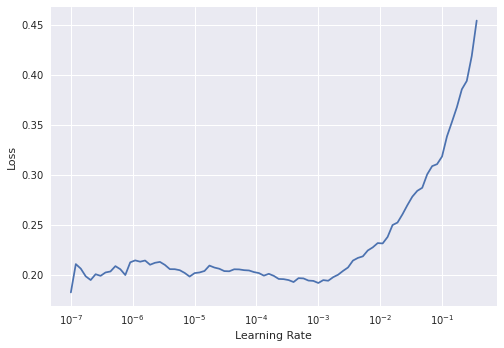

In [ ]:
learn.lr_find()

The learning rate plot looks different this time, with a flattish loss before the loss shoots up. Interpreting `lr_find` plots is not always straight-forward, especially for a model that has been unfrozen, but usually the best learning rate for a unfrozen model will be smaller than one used for the frozen model at the start of training. 

Another useful trick is that we don't just have to pick one learning rate. fastai provides support for 'differential learning rates', which apply different learning rates to different layers of the network. When looking at transfer learning in the previous lesson, we saw that the lower layers of a network often learn 'fundamental' visual features, whilst later layers are more task specific. As a result, we may not want to update our model with a single learning rate, since we want the lower layers of the network to be updated more slowly than the end layers. A simple way of using different learning rates is to use the Python `slice` function. In this case we'll try and pick a learning rate range where the model hasn't shot up yet. 

We saw above how we can save a model that we have already trained - another way to do this is to use a 'callback'. [Callbacks](https://en.wikipedia.org/wiki/Callback_(computer_programming) are sometimes used in programming to modify or change the behavior of some code. fastai includes a callback `SaveModelCallback` which as the name suggests, will save the model. By default it will save the best performing model during your training loop and load it at the end. We can also pass in the thing we want fastai to monitor to see things are improving.[^early] In this example we'll pass in `f1_score`, since this is the metric we are trying to improve. 

Let's now train the model for a few more epochs:

In [ ]:
learn.fit_one_cycle(4, lr_max=slice(6e-6, 4e-4), cbs=[SaveModelCallback(monitor='f1_score')])

epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.207510,0.192335,0.630850,0.922083,00:39
1,0.195537,0.196641,0.614777,0.917083,00:38
2,0.186646,0.197698,0.615550,0.920417,00:38
3,0.190506,0.197446,0.620416,0.920833,00:39


Better model found at epoch 0 with f1_score value: 0.6308501468079952.


# Investigating the Results of our Model 

Looking back to our diagram above, we almost always set up our model to provide some metrics which tell us how well the model is doing at a given task. In this section, we'll provide some hints on how to inspect this information in more detail.  

We seem to have not got a super well performing model in this example. But we shouldn't give up at this point. Just as we explored the data before we created our model, we will often need to explore the results of the model too. In this last section of our training loop we'll explore some of the characteristics of our model results. 

So far, we have used the metrics printed out during the training loop. We may, however, want to directly work with the predictions from the model, to give us more control over which metrics are used, and allow us to see the level of certainty behind each prediction. We can call `get_preds`. This is a method that runs our model in 'inference' mode i.e. to make new predictions. We can also use this method to run predictions on new data.

By default, `get_preds` will return the results of our model on our validation data. We also get back the correct labels. We'll store these values in `y_pred` and `y_true`. Again we use the commonplace `x` and `y` notations for data (x) and labels (y). In this case since we are working with two types of labels, we'll store them as predicted and true i.e. one is our predicted value, whilst the other is the correct label. 

In [ ]:
y_pred, y_true = learn.get_preds()

We can explore some properties of both of these variables to get a better sense of what they are:

In [ ]:
len(y_pred), len(y_true)

(600, 600)

Both `y_pred` and `y_true` have a length of 600. This is the validation part of our dataset, so this is what we'd expect since that is 30% of our total dataset size (there were 2002 rows in our `DataFrame`). Let's index into one example of `y_pred`:

In [ ]:
y_pred[0]

tensor([0.0628, 0.2345, 0.9663, 0.2955])

What does this represent? We have four values, representing each of the potential labels in our dataset. Each of these is a probability for a particular label. For a classification problem where there are clear categories, having a single class prediction is a useful feature of a model. However, if we have a set of labels or data which contain more ambiguity, then having the possibility to 'tune' the threshold of probability at which we assign a label could be very helpful. For example, we might only use predictions for a label if a model is >80% certain of a possible label. There is also the possibility of trying to work directly with the predicted label probabilities, rather than converting them to labels. 

Now we have a set of predictions and actual labels, we could directly explore these using other tools. In this example we'll use [scikit-learn](https://scikit-learn.org/stable/), a Python library for machine learning. In particular we will use the metrics module to look at our results.

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

These imported metrics should look familiar from the earlier in the lesson, where metrics were discussed. These metrics are functions to which we can pass in our predictions and true labels. 

We also pass in an `average`, which determines how our labels are averaged, this can give us more control over how the F1 score is calculated. In this case we use 'macro' as the average,which tells the function to ["Calculate metrics for each label, and find their unweighted mean"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). 

In [ ]:
f1_score(y_true, y_pred>0.50, average='macro')

0.6308501468079952

Although it could be useful to calculate different scores for our total dataset, it would be useful to have more granularity for how our model is performing. For this we can use `classification_report` from scikit-learn. 

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true, y_pred>0.50, target_names=photo_data.vocab, zero_division=1))

                 precision    recall  f1-score   support

         animal       0.67      0.13      0.22        31
          human       0.93      0.92      0.93       481
human-structure       0.79      0.72      0.75       104
      landscape       0.63      0.63      0.63        51

      micro avg       0.88      0.83      0.86       667
      macro avg       0.75      0.60      0.63       667
   weighted avg       0.87      0.83      0.84       667
    samples avg       0.91      0.89      0.86       667



We can now see a much more detailed picture of how our model is doing; we have 'precision', 'recall' and 'f1-score' broken down per label. We also have something called 'support' which refers to the number of examples of this label in the dataset. 

We can see from these results that some of our labels are performing better than others. The model does particularly well on the 'human' labels, and particularly badly on the 'animal' labels. If we look at the support for each of these we can see there are many more examples to learn from for the 'human' label (481), compared to the 'animal' label (31). This may explain some of the difference in performance of the model, but it is also important to consider the labels themselves, particularly in the context of working with humanities data and associated questions.

#### The Visual Characteristics of our Labels 
For most people, it will be clear what is meant when the concept 'animal' is referred to. There may be differences in the specific interpretation of the concept, but it will be possible for most people to see an image of something and say whether it is an animal or not. However, although it is clear what we mean by animal, this concept includes things with very different visual characteristics. In this dataset, it includes horses, dogs, cats, and pigs, all of which look quite different from one another. So when we ask a model to predict a label for 'animal', we are actually asking it to predict a range of visually fairly distinct things. This is not to say that a computer vision model couldn't be trained to recognize to recognize 'animals' by seeing examples of different specific types of animals, however in our particular dataset, this might be more difficult for a model to learn given the number and variety of examples it has to learn from. 

When using computer vision as a tool for humanities research, it is important to consider how the concepts we may wish to work with are represented visually in our dataset. In comparison to the label 'animal', which mostly an easy for the human annotator of this dataset to identify, the label 'landscape' was more difficult for the annotator to interpret[^7]. This was largely because the concept which this label was trying to capture wasn't well defined at the start of the annotation process. Did it refer to depictions of specific types of natural scene, or did it refer to a particular framing or style of photography? Are seascapes a type of landscape, or something different altogether? 

Although it is not possible to say that this difficulty in labeling this label in the original dataset directly translated into the model performing more poorly, it might point to the need to either more tightly define what is and isn't meant by this label, or to choose a new label that more closely relates to the concept you might be trying to get your model to predict. The implications and complexities of label choices and categories, particularly in a humanities context, are explored more fully in our conclusion below.

## A More Realistic Deep Learning Pipeline?

![](https://raw.githubusercontent.com/davanstrien/Programming-Historian-Computer-Vision-Lessons-submission/main/deep-learning/figs_deeplearning/deep-learning-pipeline-feedback.png)


When we introduced a deep learning pipeline, it was shown as a very linear process, but in reality, it is likely to be much more iterative. This will be particularly true if new annotations are being created, since choices will need to be made about what labels are chosen, and whether these labels are intended to be used to classify or label images. The process of annotating new data will expose you more deeply to the source material, which may flag that some labels are poorly defined and don't sufficiently capture the visual properties that you are trying to capture. It may also flag that some of your labels appear rarely, making it more challenging to train a model to predict these labels.[^retrieval] 

# 'Sucking Pigs and Sirens': Concluding Reflections on Humanities, Classification, and Computer Vision

A fan of the Argentinian writer Jorge Luise Borges, the French philosopher Michel Foucault, starts the preface of his book *The Order of Things* with an excerpt from the short essay The Analytical Language of John Wilkins: ‘This passage quotes a ‘certain Chinese encyclopedia’ in which is it is written that ‘animals are divided into: (a) belonging the Emperor, (b) embalmed, (c) tame, (d), sucking pigs, (e) sirens, (f) fabulous, (g) stray dogs, (h) included in the present classification, (i) frenzied, (j) innumerable, (k) drawn with a very fine camelhair brush, (l) et cetera, (m) having just broken the water pitcher, (n) that from a long way off look like flies.’ Being a great philosopher, Foucault ‘apprehended in one great leap’ that all systems of knowledge are limited and limit thinking (and started to write his book).   

While this lesson might have seemed rather technical, the application of computer vision techniques to investigate humanities questions could, and maybe should, include a critical reflection on the techniques themselves and their relation to our (academic) interest. As Borges’ essay makes clear, all classification is arbitrary – at least to an extent - and might be hard to justify when fundamentally questioned. For example, why do we only use the categories human, animal, structure and landscape in this lesson? Are these categories truly of the same kind? As we already noted, it might be hard for annotators to classify an image as containing a landscape. Furthermore, we could ask where this landscape is located on the image. In contrast to the category 'human', which constitutes a clearly delineable part of the image, where does a landscape start and stop? The same goes for all sorts of categories that are frequently used in computer vision research. How we see the world might not always be visible. While ‘human’ might seem like a clear category, is the same true for ‘man’ and ‘woman’? How about the category of ‘ethnicity’ (still used by border agents all over the world)? As Kate Crawford and Trevor Paglen note in their online essay Excavating AI [‘… images in and of themselves have, at best, a very unstable relationship to the things they seem to represent, one that can be sculpted by whoever has the power to say what a particular image means.’](https://www.excavating.ai/) Because computer vision techniques provide us with the opportunity to classify images (‘say what they mean’) on a large scale, the problem of classification should be central concern for humanists seeking to apply them.

We can use another short story of Borges, this time not used by Foucault but by the Italian semiotician Umberto Eco, to introduce another problem in the application of computer vision techniques. In On Exactitude in Science Borges quotes a fictional seventeenth-century book as saying: ‘In that Empire, the Art of Cartography attained such perfection that the map of a single Province occupied the entirety of a City, and the map of the Empire, the entirety of a Province.’ Since the cultural turn, many humanists have an uneasy relationship with abstraction, quantification and statistical analysis. However, as the discussion of F-scores has shown, these are vital aspects in the application of computer vision techniques to historical material: both in setting up the analysis as well as in the analysis itself. As a result, the level of abstraction should be a critical consideration for this kind of research. In classifying large collections of images, we necessarily reduce their complexities: we no longer see them fully. We should only ‘surrender’ this full view, if the abstraction tells us something new and important about the collection of images.

We hope that the application of computer vision techniques in the humanities not only benefits humanists. Being trained to take (historical) difference, complexity and contingency into account, humanists in turn could support the development of these techniques, by helping to determine the optimal scale and best categories of the legend of the map of computer vision.

## Next Steps

This section suggests some useful sources for further learning, some suggested topics for further learning which have not been fully explored in this tutorial, and some other tools that might be useful. 

### Resources

- [fast.ai](https://www.fast.ai/) has a range of resources including free online courses covering [deep learning](https://course.fast.ai/), [natural language processing](https://www.fast.ai/2019/07/08/fastai-nlp/), and [ethics](https://ethics.fast.ai/), a [book](https://www.oreilly.com/library/view/deep-learning-for/9781492045519/), and a [discussion forum](https://forums.fast.ai/). These courses have the aim of making deep learning accessible, but do dive into important details. The 'top down' approach to learning in these lessons was inspired by the approach taken in the fastai courses. 

- *The Hundred-Page Machine Learning Book*, Andriy Burkov (2019), provides a concise overview of important topics across both 'traditional' and deep learning based approaches to machine learning.

- There are a range of initiatives related to the use of machine learning in libraries, or with cultural heritage materials. This includes:
    - [ai4lam](https://sites.google.com/view/ai4lam) "an international, participatory community focused on advancing the use of artificial intelligence in, for and by libraries, archives and museums", 
    - *[Machine Learning + Libraries: A Report on the State of the Field](https://blogs.loc.gov/thesignal/2020/07/machine-learning-libraries-a-report-on-the-state-of-the-field/), Ryan Cordell (2020),* a report commissioned by the Library of Congress Labs,
    - Responsible Operations: Data Science, Machine Learning, and AI in Libraries. Padilla, Thomas. 2019. OCLC Research. [https://doi.org/10.25333/xk7z-9g97.]()

- [3Blue1Brown](https://www.youtube.com/c/3blue1brown/about) a Youtube channel by Grant Sanderson covers topics related to machine learning. The channel aims to make the mathematical concepts more easily understood through the use of animations. This may be a particularly useful resource for developing some intuitions about the maths underpinning deep learning and machine learning for those who are less familiar or comfortable with the notation used in some resources.


#### Other Tutorials 

- We plan to extend these lessons further with additional notebook based tutorials on specific techniques and concepts.

- Taylor Arnold and Lauren Tilton have tutorials available on [deep learning and image analyis](https://www.distantviewing.org/tutorial-dl).

#### Suggested Topics for Further Learning

- Ethics and power have only been briefly discussed. Ethical issues related to machine learning is an active area of discussion both inside and outside of academia. Although the issues will be slightly different when working with historical images, ethical considerations do not disappear. 

- It is worth recognising that the deep learning pipeline is only one part of a much longer process. In the case of newspapers, this begins from the publication of the newspaper and its subsequent ingestion to a collection, followed by its potential selection for digitisation. All of these steps will introduce bias into our dataset before we even begin the data preparation steps of the workflow outlined in this lesson. This is further explored by Lee, one of the creators of the Newspaper Navigator Dataset.[^lee]

- Loss and gradient descent: These lessons didn't have space to go into detail about either the specifics of the loss functions used in both of our models, or the details of how model weights are updated based on the loss. Both of these concepts are discussed in many of the resources above. A useful overview can also be found in a [3Blue1Brown](https://www.youtube.com/c/3blue1brown/about) YouTube [video](https://youtu.be/IHZwWFHWa-w)

- Though the layers of a CNN were discussed in this lesson, we didn't fully explore what each of these layers consists of. In particular understanding the 'convolution' part of CNNs will be helpful for more fully understanding how these models work.

- fastai and Pytorch: we only scratched the surface of these libraries in these lessons, it may be particularly useful to look at fastai's [datablock api](https://docs.fast.ai/tutorial.datablock) and [callbacks](https://docs.fast.ai/callback.core). 

#### Tools and Software Libraries

- [LabelStudio](https://labelstud.io/) was used to create the labeled data used in this lesson, and is relatively simple to use for a range of annotation tasks. 
- [Distant Viewing Toolkit](https://github.com/distant-viewing/dvt) is a Python package "designed to facilitate the computational analysis of visual culture"
- [PixPlot](https://github.com/YaleDHLab/pix-plot) is a tool to visualize image collections based on image similarity. 
- [Pandas](https:/pandas.pydata.org/) is often used to help prepare or load data for use in machine learning applications. Some good resources for learning more about pandas include ['Python Data Science Handbook'](https://jakevdp.github.io/PythonDataScienceHandbook/) and ['Python for Data Analysis'](https://wesmckinney.com/pages/book.html)

#### Access to a GPU 

Although it is possible to train deep learning models without a GPU, it will be a much slower experience and may be impractical for working with larger datasets, or bigger images. For a more detailed explanation of why this is, a [response](https://qr.ae/pNCu83) to a question on Quora might be helpful. The majority of deep learning libraries are intended to be run on GPU's made by [Nvidia](https://en.wikipedia.org/wiki/Nvidia). Whilst one option for accessing a GPU is to build or buy a PC with a graphics card, the setup process can be complicated and expensive. Using a cloud platform will usually be a better starting point. 

At the time of publishing this lesson [Google Colab](https://colab.research.google.com/), [Kaggle](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu), and [Paperspace](https://www.paperspace.com/) all provide access a limited amount of free GPU access. These options may change in the future; a good place to get up-to-date information on options for GPU access may be found on the fastai [forums](https://forums.fast.ai/) 

# Endnotes

[^balance]: This balanced data was generated by upsampling the minority class, normally you probably wouldn't want to start with this approach but it was done here to make the first example easier to understand. 

[^early]: A particularly useful callback is 'early stopping'. As the name suggests, this callback ['terminates training when monitored quantity stops improving.'](https://docs.fast.ai/callback.tracker#EarlyStoppingCallback).

[^retrieval]: If you are trying to find a particular type of image which rarely appears in your corpus it may be better to tackle this as an 'image retrieval' problem, more specifically ['content based image retrieval'](https://en.wikipedia.org/wiki/Content-based_image_retrieval).

[^lee]: Lee, Benjamin. ‘Compounded Mediation: A Data Archaeology of the Newspaper Navigator Dataset’, 1 September 2020. https://hcommons.org/deposits/item/hc:32415/.
